In [1]:
import os

# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")
print(os.getcwd())

/mnt/antares_raid/home/bramantyos/codes/multilang_timescale


In [2]:
import json

from typing import List, Optional
import h5py

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm import tqdm

In [62]:
from src.trainer import Trainer
from src.settings import TrainerConfig, SubjectConfig, FeatureConfig, ResultConfig

from src.plotting import plot_timescale_flatmap

from src.utils import put_values_on_mask

# scatter plot
import seaborn as sns


In [4]:
from himalaya import kernel_ridge
from himalaya.scoring import correlation_score_split, r2_score_split
from typing import Tuple
from multiprocessing import Pool

In [5]:
result_meta_dir = ".temp/result_meta/bling"

In [6]:
# scanning result meta json files and put it into a dataframe
result_meta_files = os.listdir(result_meta_dir)
result_meta_files = [f for f in result_meta_files if f.endswith(".json")]
## read json and cast it into ResultConfig
result_meta_list = []
for f in result_meta_files:
    with open(os.path.join(result_meta_dir, f), "r") as f:
        result_config = ResultConfig(**json.load(f))
        result_meta_list.append(result_config.dict())

result_meta_df = pd.DataFrame(result_meta_list)

# add result_meta_files to result_meta_df
result_meta_df["result_meta_file"] = [
    os.path.join(result_meta_dir, f) for f in result_meta_files
]

In [7]:
result_meta_df.head()

,subject_config_path,feature_config_path,trainer_config_path,result_dir,hyperparam_path,stats_path,plot_dir,result_meta_file
0,.temp/config/bling/subject/COL_zh.json,.temp/config/bling/feature/mBERT_all_timescale...,.temp/config/bling/train/trainer.json,.temp/result/bling/fbdc1eb1-1ad7-47e5-b03d-640...,.temp/result/bling/fbdc1eb1-1ad7-47e5-b03d-640...,.temp/result/bling/fbdc1eb1-1ad7-47e5-b03d-640...,.temp/result/bling/fbdc1eb1-1ad7-47e5-b03d-640...,.temp/result_meta/bling/fbdc1eb1-1ad7-47e5-b03...
1,.temp/config/bling/subject/COL_zh.json,.temp/config/bling/feature/mBERT_all_timescale...,.temp/config/bling/train/trainer_short.json,.temp/result/bling/4ae47fc7-9684-403b-931e-325...,.temp/result/bling/4ae47fc7-9684-403b-931e-325...,.temp/result/bling/4ae47fc7-9684-403b-931e-325...,.temp/result/bling/4ae47fc7-9684-403b-931e-325...,.temp/result_meta/bling/4ae47fc7-9684-403b-931...
2,.temp/config/bling/subject/COL_en.json,.temp/config/bling/feature/mBERT_all_timescale...,.temp/config/bling/train/trainer_short.json,.temp/result/bling/6575c502-0ba3-4e39-8284-e31...,.temp/result/bling/6575c502-0ba3-4e39-8284-e31...,.temp/result/bling/6575c502-0ba3-4e39-8284-e31...,.temp/result/bling/6575c502-0ba3-4e39-8284-e31...,.temp/result_meta/bling/6575c502-0ba3-4e39-828...
3,.temp/config/bling/subject/COL_zh.json,.temp/config/bling/feature/mBERT_all_timescale...,.temp/config/bling/train/trainer_short.json,.temp/result/bling/a5fc12f2-2299-4830-a0cc-490...,.temp/result/bling/a5fc12f2-2299-4830-a0cc-490...,.temp/result/bling/a5fc12f2-2299-4830-a0cc-490...,.temp/result/bling/a5fc12f2-2299-4830-a0cc-490...,.temp/result_meta/bling/a5fc12f2-2299-4830-a0c...
4,.temp/config/bling/subject/COL_en.json,.temp/config/bling/feature/mBERT_all_timescale...,.temp/config/bling/train/trainer.json,.temp/result/bling/b5f8322c-dbed-4f30-9fa8-e15...,.temp/result/bling/b5f8322c-dbed-4f30-9fa8-e15...,.temp/result/bling/b5f8322c-dbed-4f30-9fa8-e15...,.temp/result/bling/b5f8322c-dbed-4f30-9fa8-e15...,.temp/result_meta/bling/b5f8322c-dbed-4f30-9fa...


In [8]:
result_meta_df["trainer_config_path"].unique()

array(['.temp/config/bling/train/trainer.json',
       '.temp/config/bling/train/trainer_short.json'], dtype=object)

In [9]:
result_meta_df["subject_config_path"].unique()

array(['.temp/config/bling/subject/COL_zh.json',
       '.temp/config/bling/subject/COL_en.json'], dtype=object)

In [10]:
result_meta_df["feature_config_path"].unique()

array(['.temp/config/bling/feature/mBERT_all_timescale_zh.json',
       '.temp/config/bling/feature/mBERT_all_timescale_en.json'],
      dtype=object)

In [11]:
# select some results
selected_train_config = [".temp/config/bling/train/trainer.json"]
selected_feature_config = [
    ".temp/config/bling/feature/mBERT_all_timescale_en.json"
]
selected_subject_config = [
    ".temp/config/bling/subject/COL_en.json"]

# now select dataframe
selected_result_meta_df = result_meta_df.query(
    "trainer_config_path in @selected_train_config and \
                                                feature_config_path in @selected_feature_config and \
                                                subject_config_path in @selected_subject_config"
)

In [12]:
selected_result_meta_df.sort_values(['feature_config_path', 'subject_config_path', 'trainer_config_path'], inplace=True)
selected_result_meta_df.head()

/tmp/ipykernel_46347/3541877903.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_result_meta_df.sort_values(['feature_config_path', 'subject_config_path', 'trainer_config_path'], inplace=True)


,subject_config_path,feature_config_path,trainer_config_path,result_dir,hyperparam_path,stats_path,plot_dir,result_meta_file
4,.temp/config/bling/subject/COL_en.json,.temp/config/bling/feature/mBERT_all_timescale...,.temp/config/bling/train/trainer.json,.temp/result/bling/b5f8322c-dbed-4f30-9fa8-e15...,.temp/result/bling/b5f8322c-dbed-4f30-9fa8-e15...,.temp/result/bling/b5f8322c-dbed-4f30-9fa8-e15...,.temp/result/bling/b5f8322c-dbed-4f30-9fa8-e15...,.temp/result_meta/bling/b5f8322c-dbed-4f30-9fa...


# Refit and Evaluate

In [13]:
# # iter over selected_result_meta_df
# for i, row in selected_result_meta_df.iterrows():
#     result_config_path = row["result_meta_file"]
    
#     ## refit model 
#     print(f"Refitting model for {result_config_path}")
    
#     trainer = Trainer(result_config_json=result_config_path)
#     trainer.refit_and_evaluate()

# Plotting

In [63]:
en_config = result_meta_df.iloc[1].to_dict()
zh_config = result_meta_df.iloc[0].to_dict()

In [64]:
en_stats = np.load(en_config['stats_path'])
zh_stats = np.load(zh_config['stats_path'])

In [65]:
type(en_stats)

numpy.lib.npyio.NpzFile

In [66]:
en_significant_voxels, en_valid_voxel = put_values_on_mask(
    en_stats["test_r2_selectivity_mask"],
    en_stats["test_p_values_r2_mask"],
    ev_mask=None, alpha=0.05)

In [67]:
zh_significant_voxels, zh_valid_voxel = put_values_on_mask(
    zh_stats["test_r2_selectivity_mask"],
    zh_stats["test_p_values_r2_mask"],
    ev_mask=None, alpha=0.05)

In [68]:
# get the same significant voxels for both models
common_voxels = np.intersect1d(en_valid_voxel, zh_valid_voxel)

significant_en_voxels = en_significant_voxels[common_voxels]    
significant_zh_voxels = zh_significant_voxels[common_voxels]

diff = np.abs(significant_en_voxels - significant_zh_voxels)
# filter out value > 256

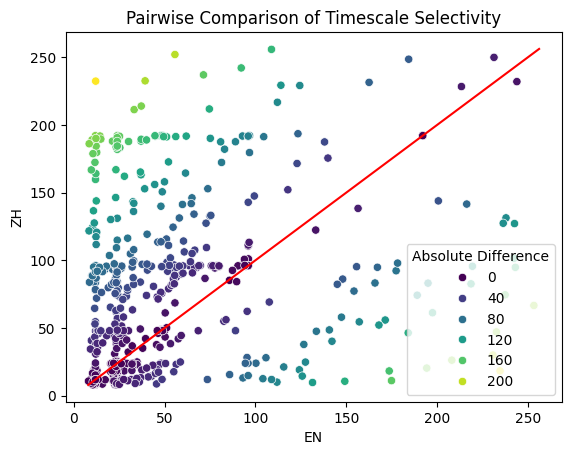

In [69]:
# scatter plot
import seaborn as sns

sns.scatterplot(x=significant_en_voxels, y=significant_zh_voxels, hue=diff, palette="viridis")

# add diagonal line
plt.plot([8, 256], [8, 256], color="red")

# limit axis to 200
# plt.xlim(8, 256)
# plt.ylim(8, 256)

plt.ylabel("ZH")
plt.xlabel("EN")

plt.title("Pairwise Comparison of Timescale Selectivity")

plt.legend(title="Absolute Difference", loc="lower right")

plt.show()

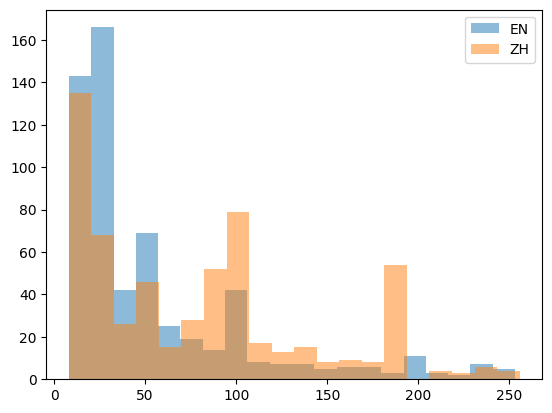

In [70]:
# histogram of significant en voxels and zh voxels



plt.hist(significant_en_voxels, bins=20, alpha=0.5, label="EN")
plt.hist(significant_zh_voxels, bins=20, alpha=0.5, label="ZH")
plt.legend()
plt.show()



In [45]:
from typing import Dict, Literal

In [71]:
def get_joint_result(first_stat, second_stat, result_type: Literal['timescale', 'accuracy'],
                     result_metric: Literal['r', 'r2'], alpha: int=0.05, ev_mask: Optional[np.ndarray]=None) -> Dict:
    if result_type == 'timescale':
        keyword = f"test_{result_metric}_selectivity_mask"
        p_val_keyword = f"test_p_values_{result_metric}_mask"
        value_range = (8,256)
    elif result_type == 'accuracy':
        keyword = f"test_joint_{result_metric}_score_mask"
        p_val_keyword = f"test_p_values_{result_metric}_mask"
        value_range = (0,1)
        
    result_first, valid_voxel_first = put_values_on_mask(
        first_stat[keyword],
        first_stat[p_val_keyword],
        ev_mask=ev_mask, alpha=alpha,
        valid_range=value_range)

    result_second, valid_voxel_second = put_values_on_mask(
        second_stat[keyword],
        second_stat[p_val_keyword],
        ev_mask=ev_mask, alpha=alpha,
        valid_range=value_range)    
    
    common_voxels = np.intersect1d(valid_voxel_first, valid_voxel_second)
    
    result_first = result_first[common_voxels]
    result_second = result_second[common_voxels]
    
    return result_first, result_second

In [107]:
def plot_joint_result(first_stat, second_stat, result_type: Literal['timescale', 'accuracy'],
                     result_metric: Literal['r', 'r2'], alpha: int=0.05, ev_mask: Optional[np.ndarray]=None):
    result_first, result_second = get_joint_result(first_stat, second_stat, result_type, result_metric, alpha, ev_mask)
    
    
    if result_type == 'accuracy' and result_metric == 'r2':
        result_first = np.sqrt(result_first)
        result_second = np.sqrt(result_second)
    
    diff = np.abs(result_first - result_second)
    
    sns.scatterplot(x=result_first, y=result_second, hue=diff, palette="viridis")

    # add diagonal line
    if result_type == 'timescale':
        plt.plot([8, 256], [8, 256], color="red", linestyle="--")
    elif result_type == 'accuracy':
        plt.plot([0, 1], [0, 1], color="red", linestyle="--")

    if result_type == 'timescale':
        plt.xlim(8, 256)
        plt.ylim(8, 256)
    elif result_type == 'accuracy':
        # get max from result first and result second
        max = np.max([result_first, result_second])
        min = np.min([result_first, result_second]) 
        plt.xlim(min, max)
        plt.ylim(min, max)
        
    plt.ylabel("ZH")
    plt.xlabel("EN")

    type_title = 'timescale selectivity' if result_type == 'timescale' else 'accuracy'
    plt.title(f"Pairwise Comparison of {type_title.capitalize()} ({result_metric.capitalize()})")

    plt.legend(title="Absolute Difference", loc="lower right")

    plt.show()
    

In [108]:
# en_r2, zh_r2 = get_joint_result(en_stats, zh_stats, result_type='timescale', result_metric='r2', alpha=0.05)
# diff = np.abs(en_r2 - zh_r2)

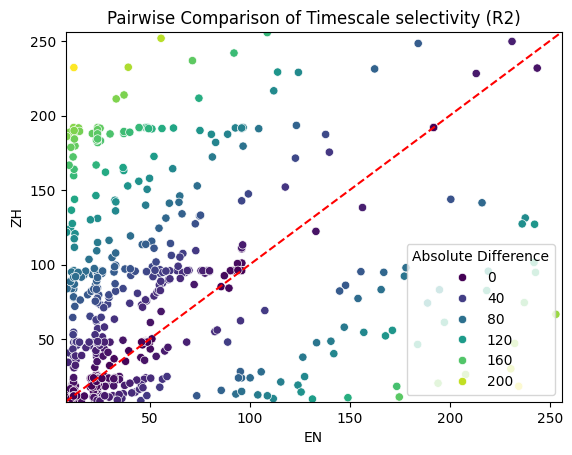

In [111]:
plot_joint_result(en_stats, zh_stats, result_type='timescale', result_metric='r2', alpha=0.05)

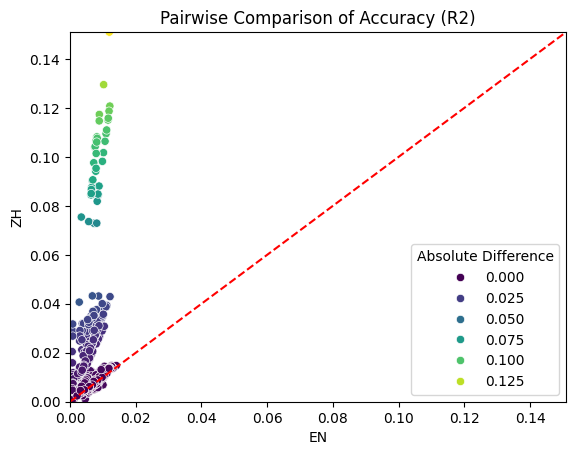

In [112]:
plot_joint_result(en_stats, zh_stats, result_type='accuracy', result_metric='r2', alpha=0.01)

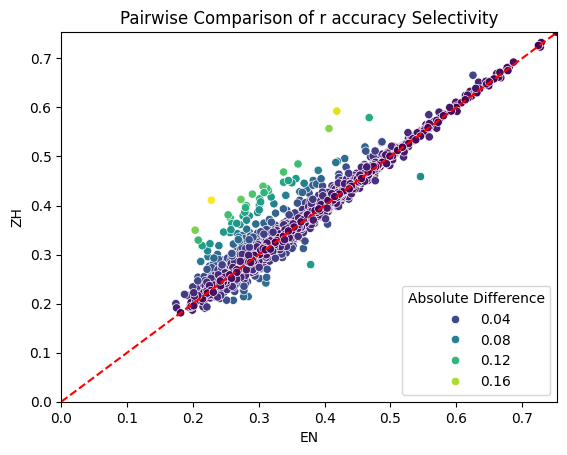

In [96]:
plot_joint_result(en_stats, zh_stats, result_type='accuracy', result_metric='r', alpha=0.01)

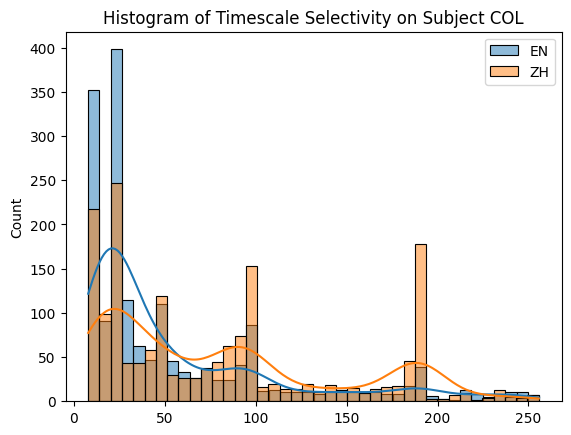

In [102]:
# histogram plot of timescale selectivity
ts_en, ts_zh = get_joint_result(en_stats, zh_stats, result_type='timescale', result_metric='r', alpha=0.05)

sns.histplot(ts_en, bins=40, alpha=0.5, label="EN", kde=True)
sns.histplot(ts_zh, bins=40, alpha=0.5, label="ZH", kde=True)

plt.title('Histogram of Timescale Selectivity on Subject COL')

plt.legend()
plt.show()